# Objective 
The objective  here is to implement couple of use cases which will demonstrate the working of Tesseract OCR with Open CV. Following are the use cases that are implemented:

* Converting the data in images to a structured format and then applying dedupe or any other DQ processes on it
* Apply various image processing technique to demonstrate the increase of OCR accuracy with image quality.

### Tesseract OCR - 
From Wiki - Tesseract is an optical character recognition engine for various operating systems.It is free software, released under the Apache License, Version 2.0 and development has been sponsored by Google since 2006.

* Github Link - https://github.com/tesseract-ocr/

### Open CV
OpenCV (Open Source Computer Vision) is a library of programming functions mainly aimed at real-time computer vision. Originally developed by Intel, it was later supported by Willow Garage then Itseez (which was later acquired by Intel). The library is cross-platform and free for use under the open-source BSD license.

OpenCV supports the deep learning frameworks TensorFlow, Torch/PyTorch and Caffe

*  Link - https://opencv.org/

# Use case 1 - Converting the data in images to a structured format

For this use case we will consider this image and try to obtain a structured format as below:

    From Name:
    From email:
    From Address:
    From Tel:
    To Name:
    To email:
    To Address:
    To Tel
    Date:
    Due Date:
    Balance Due

![title](images/NewBill.PNG)

### Installation of Tesseract 
Tesseract engine needs to be installed first followed by pytesseract which is a python wrapper for the engine.I have installed Tesseract 4.0 version as it provides an option to run LSTM engine. After installation tessdata needs to be separately downloaded and environment variables are to be explicitly set. There is a lot of documentation regarding the same online

In [29]:
from PIL import Image
import pytesseract
import cv2
import os
from pytesseract import pytesseract
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Reading the image shown above 
image = cv2.imread("D:\\Work\\Python\\OCR\\images\\NewBill.png") 

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"

In [5]:
#Setting the config entities which will be passed as input to Tesseract engine. 
# -l eng says the engine to use english words dictionary
# oem is the engine mode. 1 is - Neural net LSTM engine
# psm - page segmentation mode (It tells the engine on how to interpret the image). 3 is automatic.
# preserve_interword_spaces will help us to maintain the structure of the original image
# hocr will create the output in hocr format (Similar to xml). THe hocr will have the bbox information too. 
config = ('-l eng --oem 1 --psm 3 -c preserve_interword_spaces=1 hocr')

In [9]:
# Now let us run the tesseract engine for our image
pytesseract.run_tesseract('D:\\Work\\Python\\OCR\\images\\NewBill.png', 'output_NewBill.hocr',
                          lang=None,extension='txt', config=config)

True

Now that our output is generated. We can quickly see how the extracted text looks like. Let us verify if all the required data is extracted. If the accuracy is not good, we will have to play around with various sengementation modes and if required add additional user words as dictionary. We may have to also preprocess the image to obtain better results. We will see more of the image preprocessing in Use case 2 

In [11]:
text = pytesseract.image_to_string(image,config=config)

In [12]:
text

'Invoice 1\n\nFrom\nMaruthi Sports Manufacturers\n\nmsports@abe.com\n\n \n\nHSR Layout                                                 Sth Main, JP Nagar\nBangalore                                                           Bangalore\n\n560014                                                             560078\n\nPhone: 9711122333                                     Phone: 9722223344\n\nNumber INVO001\nDate Nov 1, 2018\nTerms 14 Days\n\nDue Nov 15, 2018\n\n \n\n \n\n \n\nDet)                                                                        ie)                                                       Amount\nTennis Kit                                7,500.00         1                7,500.00\nSubtotal                                                      37,500.00\n\nTax (0%)                                                                         20.00\n\nTotal                                                   27,500.00\n\nBalance Due                         7,500.00'

Accuracy seems to be good. However there are couple of letters like ks@abc.com which are not detected accurately

Now lets see how the hocr output looks like. This looks better structured, however accuracy can still be improved.

![title](images/Hocr_output.PNG)

Next step is to convert the extracted text in the format shown above to a json format with following tags. 

    From Name:
    From email:
    From Address:
    From Tel:
    To Name:
    To email:
    To Address:
    To Tel
    Date:
    Due Date:
    Balance Due

In [14]:
import bs4
from bs4 import BeautifulSoup
import itertools
import json

In [17]:
file = ''
with open('./output_NewBill.hocr.hocr',encoding='utf-8') as html_string:
    file = html_string.read()
soup = BeautifulSoup(file, 'html.parser')
extracted = list()
mapper = list(('From Name:','From email:','From Address:','From Tel:','To Name:','To email:','To Address:',
               'To Tel','Date:','Due Date:','Balance Due'))
len(mapper)

11

In [18]:
grpd = soup.findAll('p', attrs={'class':'ocr_par'})

In [24]:
# Function to convert the extracted text to json format
def dump_json(file_name, data):
    with open(file_name, 'w') as fw:
        json.dump(data, fw, indent=4)

In [20]:
def parse(tag):
    r=[]
    if tag and isinstance(tag,bs4.element.Tag):
        nested = []
        for t in tag.find_all('span',attrs={"class":"ocr_line"}):
            temp = []
            for tt in t.find_all('span',attrs={'class':'ocrx_word'}):
                temp.append(tt.string)
            nested.append(temp)
        r.append(nested)
    return r

In [25]:
# Depending on the format of the image we are interested in, this function will have to be modified. 
# The expectation is that we try to extract data from several images which are having same structure.
def get_data(extracted):
    out = {}
    out[mapper[0]] = " ".join(extracted[1][0][1])
    out[mapper[1]] = "".join(extracted[1][0][2])
    out[mapper[2]] = " ".join([*itertools.chain.from_iterable(extracted[2][0])])
    out[mapper[3]] = "".join(extracted[3][0][0]).partition(":")[2]
    out[mapper[4]] = None
    out[mapper[5]] = None
    out[mapper[6]] = " ".join([*itertools.chain.from_iterable(extracted[7][0])])
    out[mapper[7]] = "".join(extracted[8][0][0]).partition(":")[2]
    out[mapper[8]] = " ".join(extracted[4][0][1][1:])
    out[mapper[9]] = " ".join(extracted[5][0][0][1:])
    out[mapper[10]] = "".join(extracted[15][0][0][2:])
    return out

In [22]:
for tags in grpd:
    extracted.append(parse(tags))
data = get_data(extracted)

In [23]:
from pprint import pprint
pprint(data,indent=4)
dump_json('./output.json',data)

{   'Balance Due': '7,500.00',
    'Date:': 'Nov 1, 2018',
    'Due Date:': 'Nov 15, 2018',
    'From Address:': 'HSR Layout Bangalore 560014',
    'From Name:': 'Maruthi Sports Manufacturers',
    'From Tel:': '9711122333',
    'From email:': 'msports@abe.com',
    'To Address:': '5th Main, JP Nagar Bangelore 560078',
    'To Name:': None,
    'To Tel': '9722223344',
    'To email:': None}


There are couple of tags which were not extracted. We will need to have a look at them to see how we can get those records. But this is good enough to show how the image data can be converted to structured format. This json can now be loaded to database table or passed to any other processes to obtain various statistics.Various possibilities will now open up to consume this structured data.

# Use Case 2 - Apply various image processing technique to demonstrate the increase of OCR accuracy

Having extracted the text from a fairly good quality image in Use case 1. Let us try to extract text from a more real world example. We will consider the following image and see how improving the image quality will help derive more insights. This is a scanned image and the quality of image is poor. These are the kind of images which employees submit as proofs of expenditure or for tax savings etc. 
In most of the cases, somone has to manually browse through the images to ascertain their veracity and to manually convert them into structured format. Let us see how OCR can help us in such cases

![title](images/bill_1.jpg)

In [26]:
# Let us now try to load this image and extract the text without doing any processing and see how the result 
# will look like. 
img_2 = cv2.imread("D:\\Work\\Python\\OCR\\images\\bill_1.jpg") 
config = ('-l eng --oem 1 --psm 3 -c preserve_interword_spaces=1')
text_2 = pytesseract.image_to_string(img_2,config=config)

In [27]:
text_2

'1 No  Waiter\n\nABéis    WAITER\nsais               Price\n\nSe tt em net iw SS re e-em Sn Sm     on ane wn ee ee ome own aw\n\nFLAVOURED MOJITO  380. 00   1,000 33\n\nSUCUNBER MINT     70000 1.000 170.0\nLONG ISLAND ELEC 340.00 2.0%\nQRUNCHY SALAD     160.00 1.000\nASSORTED SATAY 260.00 1.00¢\n\nTEQUILA CHICKEN 320,00 1.000\nFAJITAS CHICKEN 300.00 1.0UC\nSURF N TURF       360.00 1.000\nTota) Quantity             9.00\nGross Tota!\nVAT 5.5%\nVAT 14.5%\n\nService Tax 5.6%\n\n| Service Charges 10.00%\n\n~ Net Amount\n\nGet Back Joe Joe)\n\nA Re i i A Nin a tk A RE Sr ie\n\n \n\ni'

It doesnt look so good. There is lot of text which has not been detected. Accuracy is less than 50% 

We will resize the image and see if the results get better

In [28]:
img_2 = cv2.resize(img_2, None, fx=2.5, fy=2.5, interpolation=cv2.INTER_CUBIC)
text_2 = pytesseract.image_to_string(img_2,config=config)
text_2

"dt.\n‘hk.  be, Meue\nos     .    f\nas\nrat =\n' ee ther  han J\ni. VARs, 3 ‘&\nms  ;    ~\nher ow   :   4  A -\ny  '   Nal tea? Sf\n an a ee\n7 IN   etm ; os\n| > . 4  den Ye: wh &\nAan\nf i  —  ba\nee \\     . &\n—       —. i, Ck ho ome > »     ~~    - :\n-_ ;       ~\n. om\nBi) ‘  Na   we  ter      INC    A wa '\n-_-_—         we        a  ~ =~ we —- ~\n_  —   ~   \\ *  on\n— Tee rm      Va hk   iw  a Lt   1) ao\n1 5 F   ;    3     le  i   |\nageis    WAITER D015 UO/U0/2UI-\nee OND cae ee Oe Sto: er em a ee ee => vee, anh Oo ®  > to   me  _—\n\nitem               Price    Oty\n\nFLAVOURED MOJITO  330, 00   1,000 330.00\nUUNBER MINT     WONG) 1.000 170.00\n\nONG ISLAND ELEC 340.00   6 .00U  +80 .00\n\nCRUNCHY  ¥ SALAD     160.00 1.\n\nASSORTED SATAY 260,00 1.000 26...\n\nTEQUILA CHICKEN 320.00   0  326 . 0\n\nFAJITAS CHICKEN 300.00 |      100\n\nSURF N TURF       360.00 1\n\nTota) Quantity           9.000\n\nGross Tota!\n\nVAT 5.5%                         65.86\n\nVAT 14.5%         

Much better but not good enough. Accuracy has increased slightly

As a next step we will binarize the image. We will remove the color quotient from the image and we will binarize it.
Any pixel having the value greater then the set threshold will be converted to white and the pixels whose values 
are less than the threshold are turned to black. There are various ways of applying this thresholding, and we will look
at those and see which one is better. 

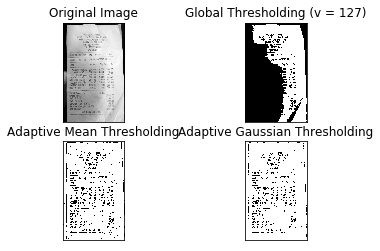

In [42]:
img_2 = cv2.imread('D:\\Work\\Python\\OCR\\images\\bill_1.jpg',0)
img_2 = cv2.medianBlur(img_2,5)
ret,th1 = cv2.threshold(img_2,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img_2,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img_2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img_2, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

From the images above, its very clear that Global thresholding will not be useful for us and we will have to go with either of the remaining two. Adaptive Gaussian Thresholding looks better though as it appears there is lot more of noise introduced in the Adaptive Mean Thresholding approach. We will save these and have a closer look

In [43]:
cv2.imwrite('th2-ADmean.png',th2)
cv2.imwrite('th2-ADGaussian.png',th3)

True

### Adaptive Mean Thresholding 

![title](th2-ADmean.png)

### Adaptive Gaussian Thresholding.

![title](th2-ADGaussian.png)

Although there is lot more noise in Mean, the image is sharper. So lets try to get the text out of Mean thresholded image now. 

In [45]:
text_2 = pytesseract.image_to_string(th2,config=config)
text_2

'oe      “TRE Local. DINERS |\n07s,  4th Cross, -2nd Block,           fos\noes RRBR Layout, Kalyan Nagar, a ae ay\nBANGALORE-560 043°         oe\nPH: 080 °41440067 aes\nTIN: 29081176093...\nos QASH/BILL\n\nve Bernt cnn sen nr ncn ee 7\n\n7 Bill No- Waiter ©\n\n:    ee Ae nate\n\n                                                                                                                                                                     \n  \n\nae we eae wee oe veneer eenne .-\n\nme ee ween nnn e nnn ene nner nad\n\novo} FLAVOURED NOUITO  330,00 1,000 330,00.. °° |\n~¥" CUCUNBER MINT: .170.00..,1.000 170.00 0. |\n~. ¢ LONG ISEAND™ ELEC”  “940.007. 2,000 G80.00°°\n_-} CRUNCHY SALAD~--.- 180. 00-° 1,000. 180.00\n" f ASSORTED SATAY 260.00 1.000 260.00\n“ef TEQUILA CHICKEN’ 320.00, 1,000 320.00 °F\nA | FAJTTAS CHICKEN 300.00°- 1, 000 .300:60 =\n7 SURF N-TURF 960.00 - 1,000. 360.00 oot\n\n   \n\n   \n                                                                                       

This looks much better. Much more text has been extracted. Accuracy can be improved though

In the next step we will apply a 5*5 filter to which will take the median of the pixels in the filter window. This might remove the salt and pepper noise that we see above , which inturn will help us to remove unwanted charecters that are currently being extracted. 

In [46]:
img = cv2.medianBlur(th2,5)

In [48]:
cv2.imwrite('th2-Admean-blur.png',img)

True

Lets see how the image looks like now.

![title](th2-Admean-blur.png)

We can see that substantial amount of noise has been removed now. Lets see how the extracted text looks like now.

In [47]:
text_2 = pytesseract.image_to_string(img,config=config)
text_2

'.   0 OD OP OP Oh On ate GS 2s On OR be on ob Ob OF Oe OD Dey OR EY ~\n\n— . . THE LOCAL DINERS    |\n-. #2075, dth Cross, 2nd Block,\nHRBR Layout Kalyan Nagar,.\nBANGALORE-560 043\nPH: 080 41440067\n\nTIN: 29081176093\nCASH/BILL\n\nFLAVOURED NOJITO 330.00 1.000 330.00\nCUCUMBER MINT . 170.00 _1.000 170.00\n\nLGNG ISLAND ELEC™ 340.00°° 2.000 G80.00_\n\nCRUNCHY SALAD 160.00 1.000 160.00\nASSORTED SATAY 260.00 1.000 266.00\nTEQUILA CHICKEN 320.00 1.000 326.00\n\n“1. EAUTTAS CHICKEN 300.00 1,000 300.60\n\nSURF N TURF       360.00 1.000 360.09\nTota) Quantity .         9,000\n\nGross Total —     .              2560.00 |\nVAT 5.5% 0       “95,55\n\nVAT 14.5%      |        227.65 |\nService Tax 5.6 %      ms    158.98\n\n- Service Charges 10. 00%        > 268.00\n\nNet Anount                    — 92an.do-\n\n- Get Back Joe Joe!        ,\n\nee ee ee ee ee ey\n\n \n\npart pet'

What we see is extracted text is now better structured.Inwanted charecter no longer appears.Gross Amount and Net amount are still not accurate through. We can further explore and localize only those parts of the image and improve the accuracy further which I wont be getting into now. As a last step, I will try to reduce the size of the kernal (filter) from 5*5 to 3*3 to see if there is a difference.

In [51]:
img = cv2.medianBlur(th2,5)
cv2.imwrite('th2-Admean-blur_3.png',img)

True

In [52]:
text_2 = pytesseract.image_to_string(img,config=config)
text_2

'.   0 OD OP OP Oh On ate GS 2s On OR be on ob Ob OF Oe OD Dey OR EY ~\n\n— . . THE LOCAL DINERS    |\n-. #2075, dth Cross, 2nd Block,\nHRBR Layout Kalyan Nagar,.\nBANGALORE-560 043\nPH: 080 41440067\n\nTIN: 29081176093\nCASH/BILL\n\nFLAVOURED NOJITO 330.00 1.000 330.00\nCUCUMBER MINT . 170.00 _1.000 170.00\n\nLGNG ISLAND ELEC™ 340.00°° 2.000 G80.00_\n\nCRUNCHY SALAD 160.00 1.000 160.00\nASSORTED SATAY 260.00 1.000 266.00\nTEQUILA CHICKEN 320.00 1.000 326.00\n\n“1. EAUTTAS CHICKEN 300.00 1,000 300.60\n\nSURF N TURF       360.00 1.000 360.09\nTota) Quantity .         9,000\n\nGross Total —     .              2560.00 |\nVAT 5.5% 0       “95,55\n\nVAT 14.5%      |        227.65 |\nService Tax 5.6 %      ms    158.98\n\n- Service Charges 10. 00%        > 268.00\n\nNet Anount                    — 92an.do-\n\n- Get Back Joe Joe!        ,\n\nee ee ee ee ee ey\n\n \n\npart pet'

# Conclusion 

In use case 1, we saw how we can convert the image data from unstructured to structured format. Structurizing any data will help us to gather more insights. 

In use case 2, we saw how the quality of image can be improved by various image processing technique which in turn will help us in getting more accurate OCR output. 

We saw how various image related data quality problems can be addressed